In [2]:
#########################################################################
# Jupyter notebook for analysis of alcaloid similarities;               #
# Created by Elena Maria Beck and Michael Edmund Beck, November 2021    #
# supplement to "A conserved hymenopteran-specific family of cytochrome #
# P450s protect bee polinators from toxic nectar alkaloids"             #
#########################################################################

In [3]:
from rdkit import Chem
from rdkit.Chem import AllChem       # enable Morgan fingerprints
from rdkit.Chem import Draw          # enable drawing molecules
from rdkit import DataStructs        # enable similarity calculation
from matplotlib import pyplot as plt # histogram plot
from rdkit.Chem import MACCSkeys     # gues what ... 
from itertools import *              # iterators and stuff
import seaborn as sns                # enable clustering and heatmap
import numpy as np                   # matrix and array manipulations
import pandas as pd                  # data frames
import matplotlib.pyplot as plt
import networkx as nx

In [4]:
# create data set, manually, from SMILES codes
data = np.array([
    ["C=1C=C([C@]2(N(CCC2)C)[H])C=NC1","(S)-Nicotine"],
    ["C1CCC(NC1)c1cccnc1", "Anabasine"],
    ["CN1[C@H]2CC[C@@H]1C[C@@H](C2)OC(=O)C(CO)c1ccccc1","Atropine"],
    ["O=c1cccc2[C@H]3CNC[C@H](C3)Cn12", "Cytisine"],
    ["C\C=C(\C)C(=O)O[C@@H]1CCN2CC=C(COC(=O)[C@@](O)([C@H](C)O)C(C)(C)O)[C@H]12", "Echimidine"],
    ["CN1[C@H]2C[C@@H](C[C@@H]1[C@H]1O[C@@H]21)OC(=O)[C@H](CO)c1ccccc1","Scopolamine"],
    ["CN1C=NC2=C1C(=O)N(C(=O)N2C)C","Caffeine"],
    ["O=C1C=Cc2ccccc2O1", "Coumarin"]]
    )
smiles = [a[0] for a in data]
molNames =[a[1] for a in data]

In [5]:
# create molecule objects from smiles
mols = pd.DataFrame([Chem.MolFromSmiles(x) for x in smiles],index=molNames)
molImages = pd.DataFrame([Draw.MolToImage(m) for m in mols[0]],index=mols.index)

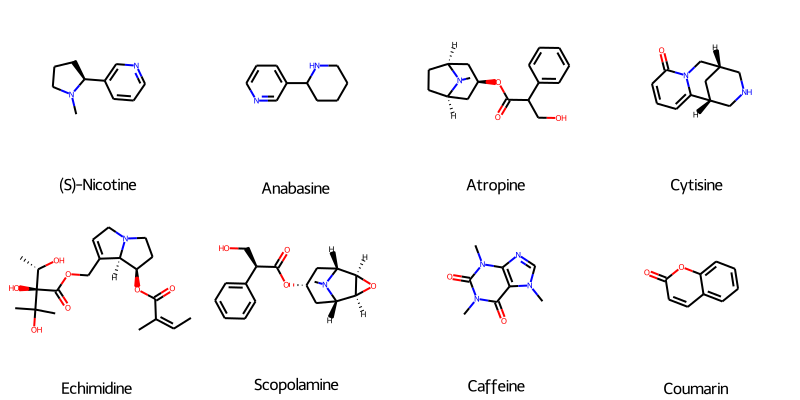

In [6]:
# Have a look at what we've got
Draw.MolsToGridImage(mols[0], molsPerRow=4, subImgSize=(200,200), legends=[str(x) for x in mols.index] )

In [7]:
# calculate fingerprints
Morgan2FP = [AllChem.GetMorganFingerprint(m,2,useFeatures=True) for m in mols[0]]

In [8]:
# calculate similarity matrices, as a data frame
SimilaritiesDice2 = pd.DataFrame(
    np.array([[round(DataStructs.DiceSimilarity(a,b),2) for b in Morgan2FP] for a in Morgan2FP]),
    columns=mols.index, index = mols.index)
# look at the results
SimilaritiesDice2

,(S)-Nicotine,Anabasine,Atropine,Cytisine,Echimidine,Scopolamine,Caffeine,Coumarin
(S)-Nicotine,1.00,0.68,0.40,0.37,0.18,0.39,0.28,0.27
Anabasine,0.68,1.00,0.35,0.44,0.11,0.32,0.27,0.26
Atropine,0.40,0.35,1.00,0.36,0.36,0.88,0.21,0.30
Cytisine,0.37,0.44,0.36,1.00,0.14,0.35,0.33,0.38
Echimidine,0.18,0.11,0.36,0.14,1.00,0.38,0.09,0.02
Scopolamine,0.39,0.32,0.88,0.35,0.38,1.00,0.20,0.29
Caffeine,0.28,0.27,0.21,0.33,0.09,0.20,1.00,0.32
Coumarin,0.27,0.26,0.30,0.38,0.02,0.29,0.32,1.00


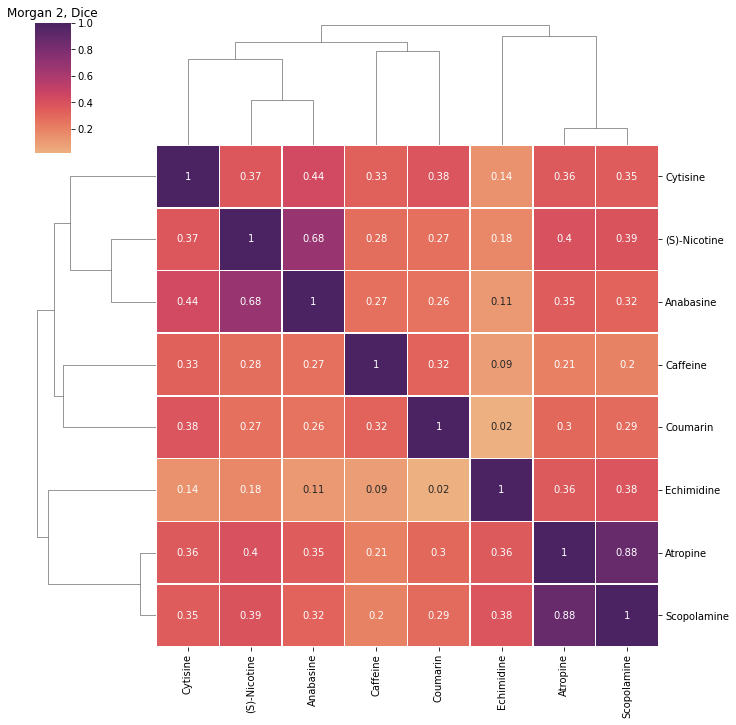

In [9]:
# hierarchical clustering and heatmap
sns.clustermap(SimilaritiesDice2,annot=True, linewidths=.5, cmap="flare")
plt.title("Morgan 2, Dice")
plt.show()

In [10]:
#
# a simple sub for creation and visualisation of a similarity network
#
def similarityNetwork(**kwargs):
    #
    # Usage::
    #
    # similarityNetwork(simMat=<data frame>, thresh=<float>[, notebook =<boolean>][,html=<filename>])
    #
    simMat = kwargs.get('simMat') # data frame containing the similarity matrix
    thresh = kwargs.get('thresh') # similarity threshod
    networkName = kwargs.get('plotTitle','similarity')
    noteBookFlag = kwargs.get('notebook', True) # visualize in notebook or new boweser window?
    htmlFile = kwargs.get('html', 'test.html')  # 
    if not isinstance(noteBookFlag, (bool)):
        noteBookFlag = True
            
    # select a similarity matrix and a threshold
    #simMat = ECFP2SimilaritiesDice
    #thresh = 0.4
    scale = 1.0

    from pyvis.network import Network
    
    titleStr = str(networkName)+"; threshold="+str(thresh)
    
    net = Network(notebook=noteBookFlag,height='1000px', width='100%',heading=titleStr)

    # set network display options
    if noteBookFlag:
        net.set_options('''
        var options = {
          "nodes": {
            "font": {
              "size": 22
            },
            "shape": "text",
            "shapeProperties": {
              "borderRadius": 7,
              "useImageSize": true
            }
          },
          "edges": {
            "color": {
              "inherit": true
            },
            "font": {
              "size": 22
            },
            "smooth": false
          },
          "physics": {
            "barnesHut": {
              "gravitationalConstant": -10400,
              "centralGravity": 0,
              "springLength": 145,
              "springConstant": 0.05,
              "damping": 0.09,
              "avoidOverlap": 0.41
            },
            "minVelocity": 0.75
          }
        }
        ''')

    # add nodes (aka molecules)
    for m in mols.index:
        net.add_node(m,
                     label=m)#,color='rgba(0,0.9,0.9,1)')#,image=molImages[0][m])

    scale = 1.0

    # create edges (aka pairwise similarities),
    # for all connections with a weight( aka similarity) exceeding.d the threshold
    for (i,j) in combinations(simMat.index,2):
        
        if simMat[i][j] > thresh:
            labStr = str(round(100*simMat[i][j]))+"%" # just a string like "72%"
            simStr = str(round(simMat[i][j],2))       # just a string like "0.72"
            net.add_edge(i,j, 
                         weight=simMat[i][j], 
                         value=simMat[i][j]*scale, 
                         label=labStr,
                         font='arial',
                         size=36)#,
                         #color='rgba(1,0.5,0,'+simStr+')') #title=simMat[i][j])
            # for more options see: https://visjs.github.io/vis-network/docs/network/edges.html

    # actual network properties
    #net.enable_physics(True)
    if not noteBookFlag:
        net.show_buttons() 
    # net.set_options('var options = {"physics": {"hierarchicalRepulsion": { "centralGravity": 0,"nodeDistance": 170},    "minVelocity": 0.75,   "solver": "hierarchicalRepulsion"  }}')
    return net.show(htmlFile)


In [11]:
similarityNetwork(simMat=SimilaritiesDice2, thresh=0.30, html="Alkaloids_Similarity_Graph.html")